In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from joblib import dump
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading datasets
weather = pd.read_csv('dataset/train_timeseries.csv')
soil = pd.read_csv('dataset/soil_data.csv')

print(weather.shape)
print(soil.shape)
weather.head(), soil.head()


(19300680, 21)
(3109, 32)


(   fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
 0  1001  2000-01-01     0.22  100.51   9.65  14.74   13.51   13.51    20.96   
 1  1001  2000-01-02     0.20  100.55  10.42  16.69   14.71   14.71    22.80   
 2  1001  2000-01-03     3.65  100.15  11.76  18.49   16.52   16.52    22.73   
 3  1001  2000-01-04    15.95  100.29   6.42  11.40    6.09    6.10    18.09   
 4  1001  2000-01-05     0.00  101.15   2.95   3.86   -3.29   -3.20    10.82   
 
    T2M_MIN  ...     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
 0    11.46  ...  14.65   2.20       2.94       1.49         1.46   4.85   
 1    12.61  ...  16.60   2.52       3.43       1.83         1.60   5.33   
 2    15.32  ...  18.41   4.03       5.33       2.66         2.67   7.53   
 3     2.16  ...  11.31   3.84       5.67       2.08         3.59   6.73   
 4    -2.66  ...   2.65   1.60       2.50       0.52         1.98   2.94   
 
    WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
 0       6.04

In [3]:
# Check uniqueness and duplicates
print("weather fips unique:", weather['fips'].nunique())
print("soil fips unique:", soil['fips'].nunique())

weather fips unique: 3108
soil fips unique: 3109


In [4]:
# Drop duplicate fips in soil 
soil = soil.drop_duplicates(subset='fips')

In [5]:
# Merge datasets
data = weather.merge(soil, on='fips', how='inner')
print("merged data shape:", data.shape)

data.head()

merged data shape: (19300680, 52)


,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2


In [6]:
# Remove rows without drought_severity score
data = data[data['score'].notna()]

In [7]:
# Drop irrelevant/sparse columns (>50% NaNs)
data.dropna(thresh=len(data) * 0.5, axis=1, inplace=True)

In [8]:
# Convert date if exists
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data.drop('date', axis=1, inplace=True)

data.head()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,year,month,day
3,1001,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,...,1,1,1,1,1,1,2,2000,1,4
10,1001,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,13.16,...,1,1,1,1,1,1,2,2000,1,11
17,1001,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,9.06,...,1,1,1,1,1,1,2,2000,1,18
24,1001,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,11.11,...,1,1,1,1,1,1,2,2000,1,25
31,1001,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,15.23,...,1,1,1,1,1,1,2,2000,2,1


In [9]:
numeric_cols = data.select_dtypes(include=np.number).columns
for col in numeric_cols:
    mean = data[col].mean()
    std = data[col].std()
    data = data[(data[col] >= mean - 3 * std) & (data[col] <= mean + 3 * std)]

print("data shape after outlier removal:", data.shape)

data shape after outlier removal: (1614350, 54)


In [10]:
# set the correct target column
target = 'score'

# separate features and target
X = data.drop(columns=[target])
y = data[target]

# standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_scaled.head()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,year,month,day
0,-2.019241,0.273082,1.132165,-0.138365,0.029634,0.073685,0.072142,0.024200,-0.251466,0.789973,...,1.248875,0.90192,-0.091722,2.084407,0.0,0.0,0.0,-1.619097,-1.631661,-1.327415
1,-2.019241,-0.502932,1.152292,0.220041,0.122602,0.498906,0.498336,0.149949,0.182729,-0.053634,...,1.248875,0.90192,-0.091722,2.084407,0.0,0.0,0.0,-1.619097,-1.631661,-0.531544
2,-2.019241,-0.462223,1.159000,0.515569,0.323267,0.723023,0.723495,0.225049,0.484280,-0.677523,...,1.248875,0.90192,-0.091722,2.084407,0.0,0.0,0.0,-1.619097,-1.631661,0.264328
3,-2.019241,-0.520742,1.055014,-1.104595,-0.951598,-1.143949,-1.142108,-0.926776,-0.861248,-0.430680,...,1.248875,0.90192,-0.091722,2.084407,0.0,0.0,0.0,-1.619097,-1.631661,1.060199
4,-2.019241,-0.510565,1.323366,-0.861465,-0.669931,-0.685711,-0.689779,-0.532937,-0.683753,0.285436,...,1.248875,0.90192,-0.091722,2.084407,0.0,0.0,0.0,-1.619097,-1.338105,-1.668503


In [11]:
# Round scores to nearest integer and convert to int
y = y.round().astype(int)

# Check the distribution
print(y.value_counts())

score
0    1013797
1     274019
2     165191
3     105290
4      56053
Name: count, dtype: int64


In [12]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

print("Resampled X shape:", X_res.shape)
print("Resampled y distribution:\n", y_res.value_counts())

Resampled X shape: (5068985, 53)
Resampled y distribution:
 score
1    1013797
2    1013797
3    1013797
4    1013797
0    1013797
Name: count, dtype: int64


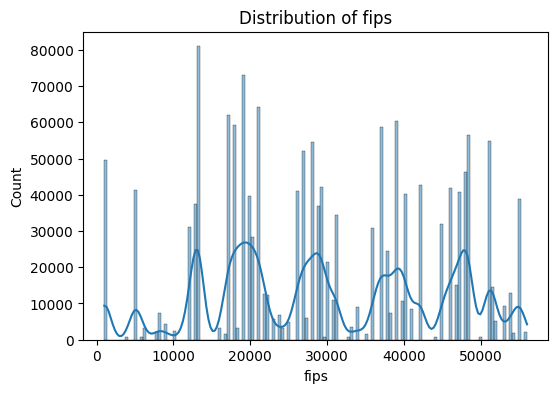

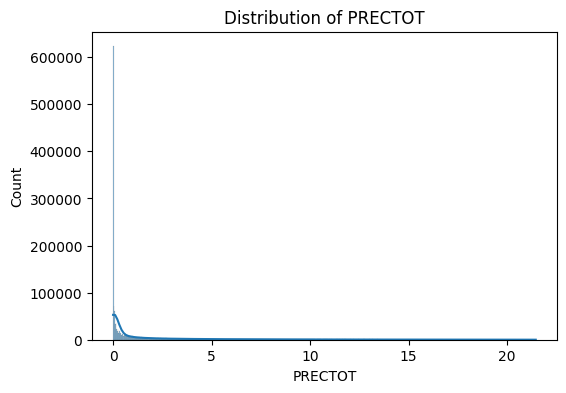

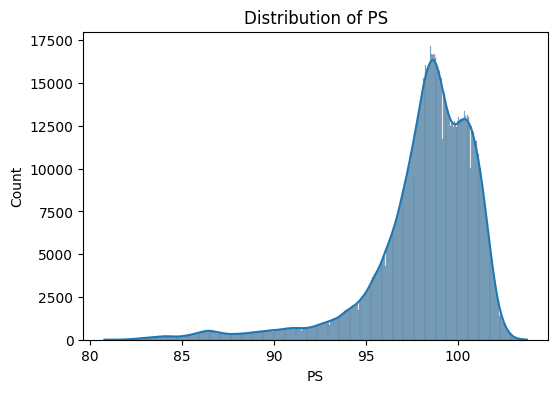

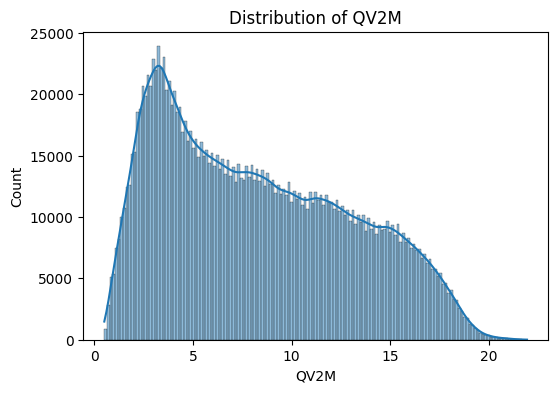

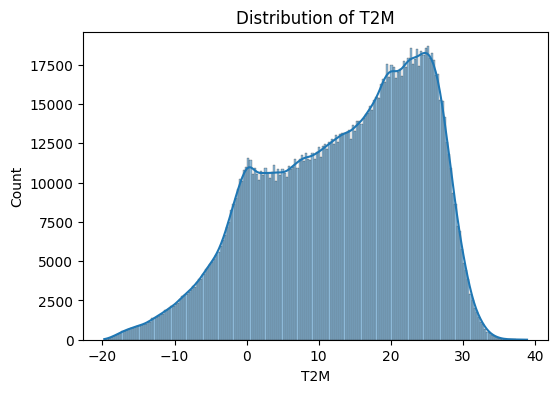

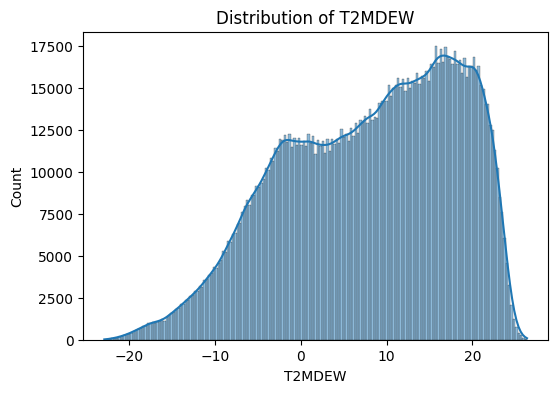

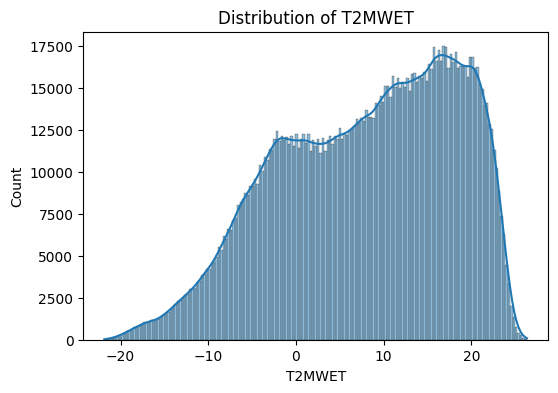

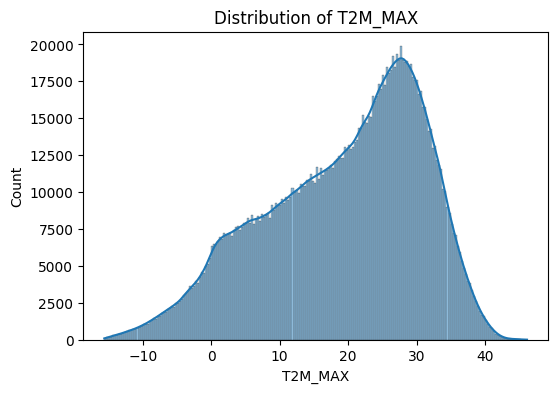

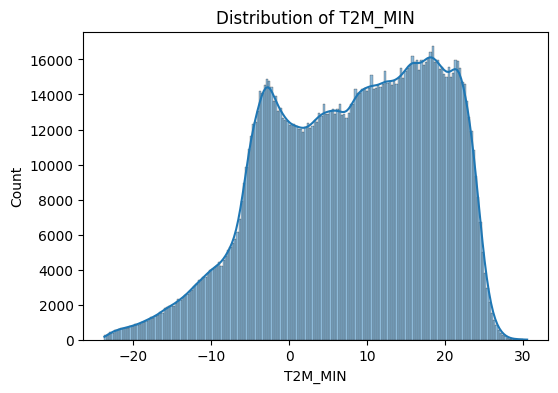

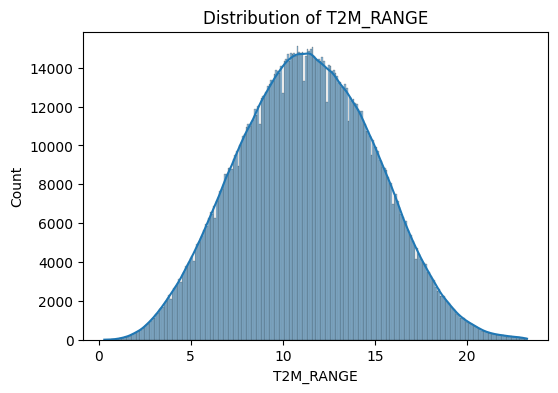

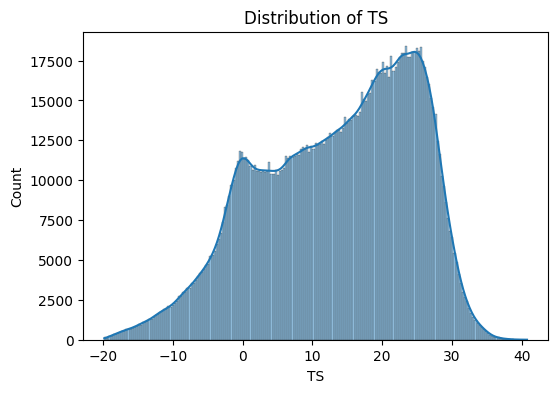

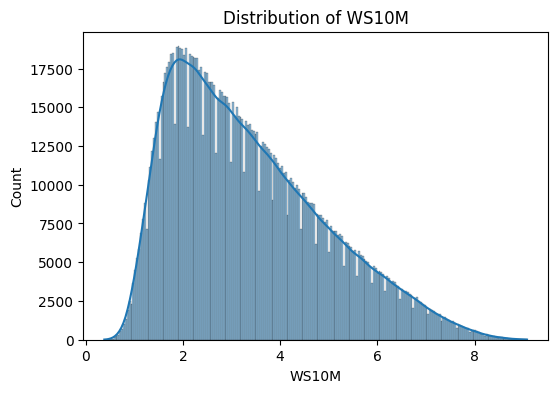

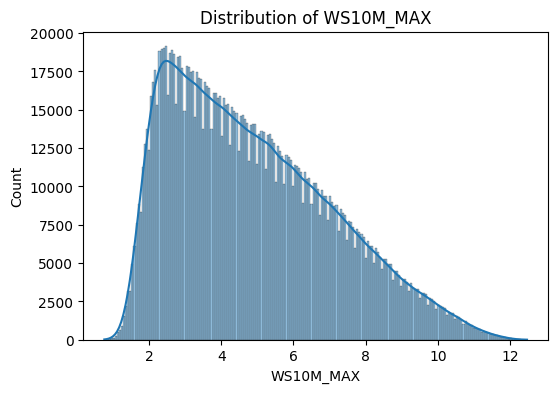

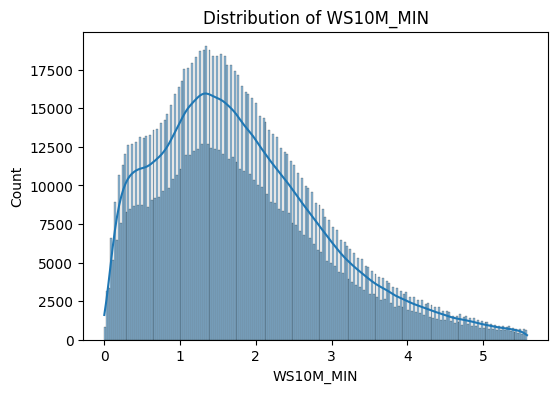

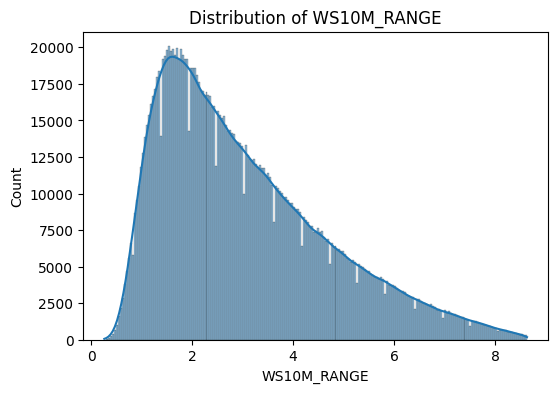

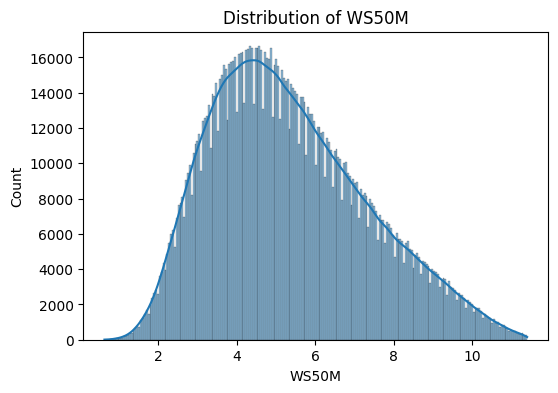

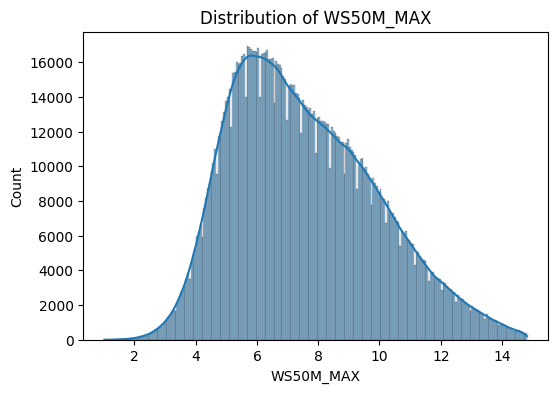

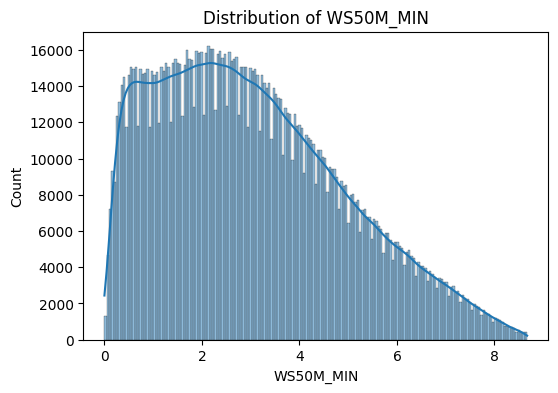

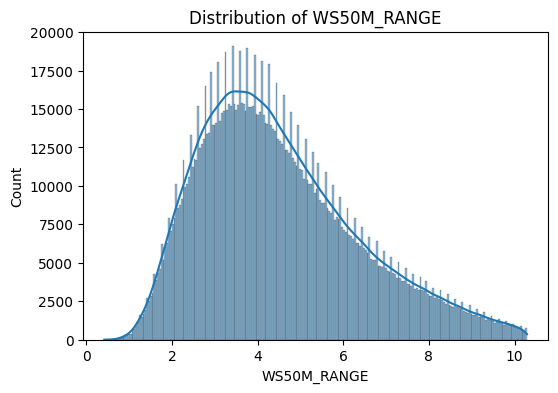

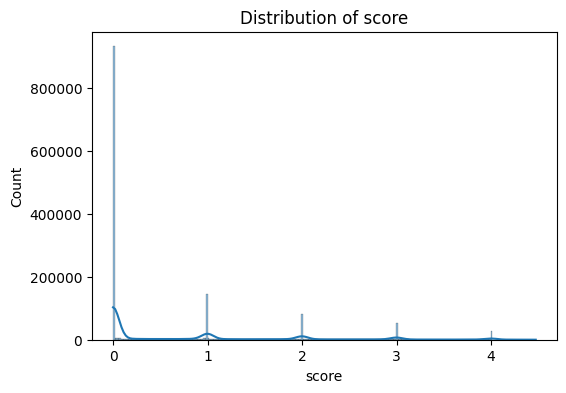

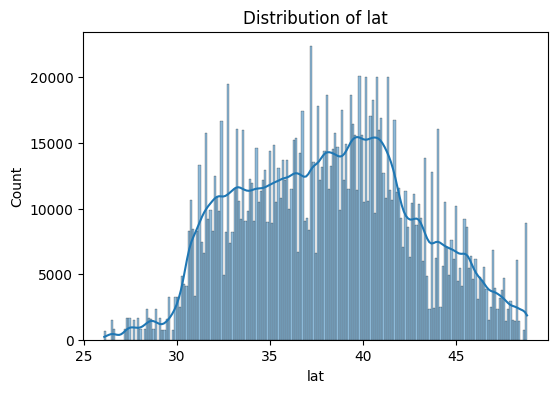

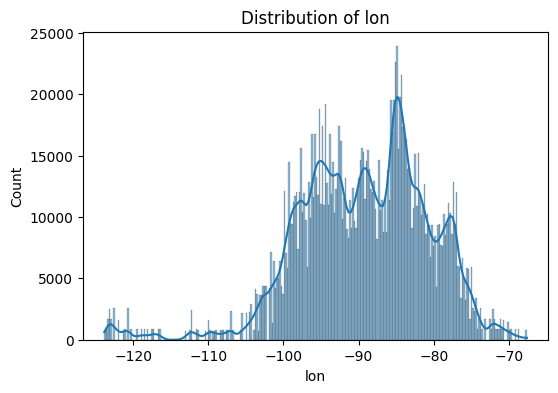

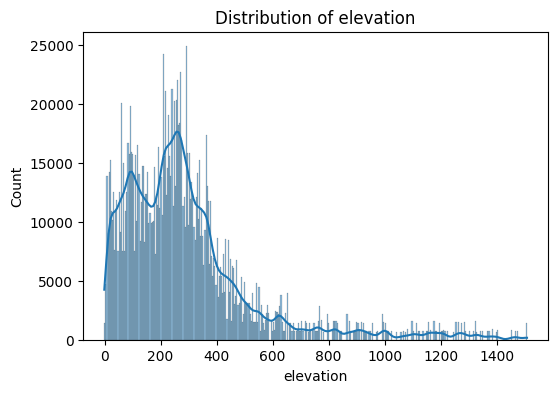

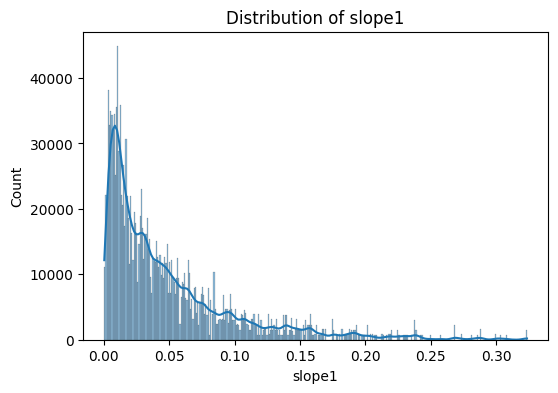

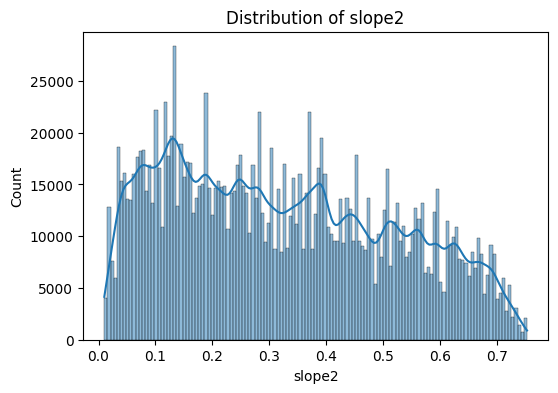

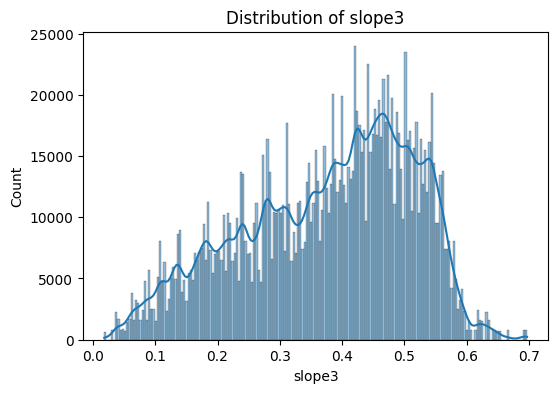

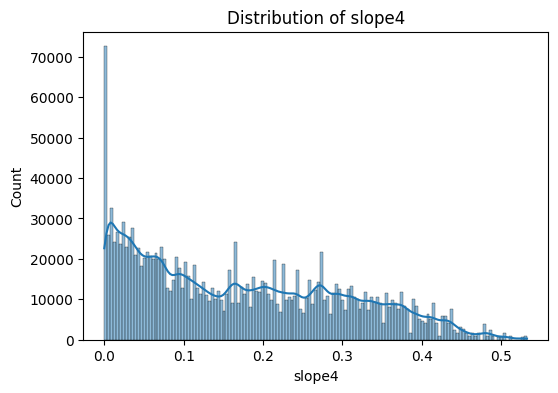

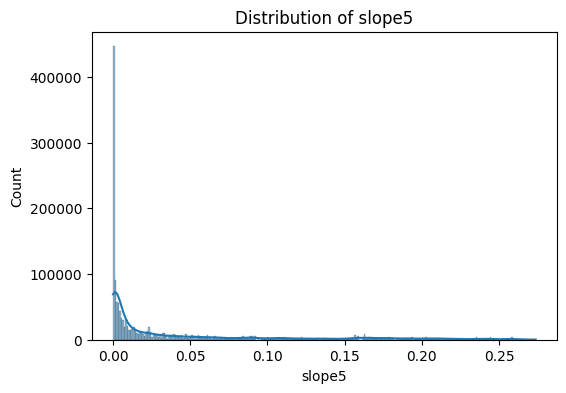

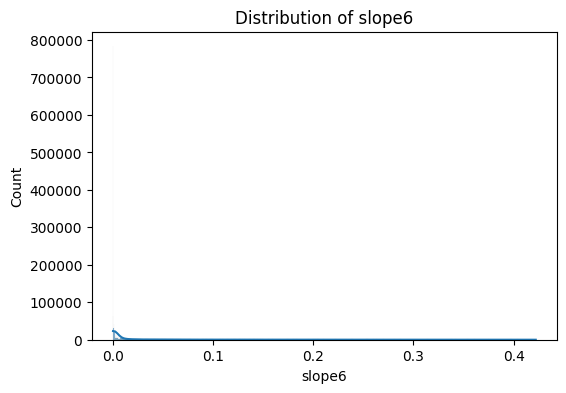

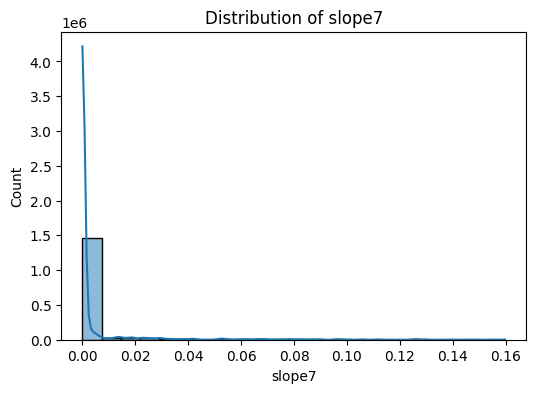

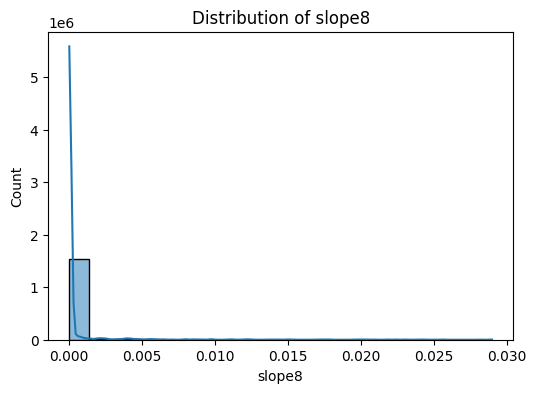

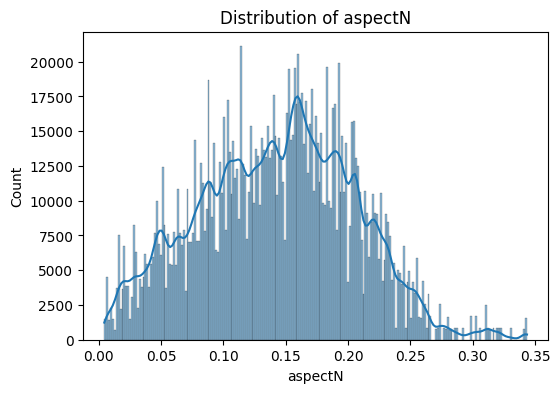

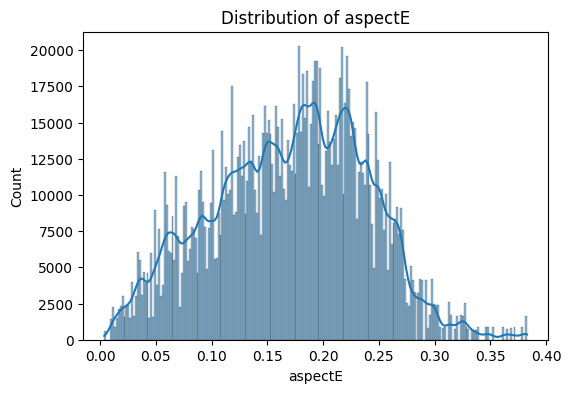

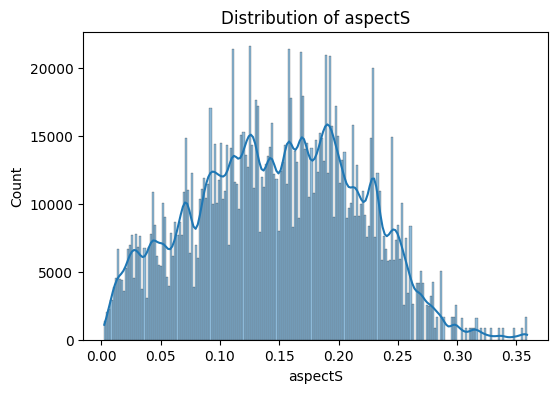

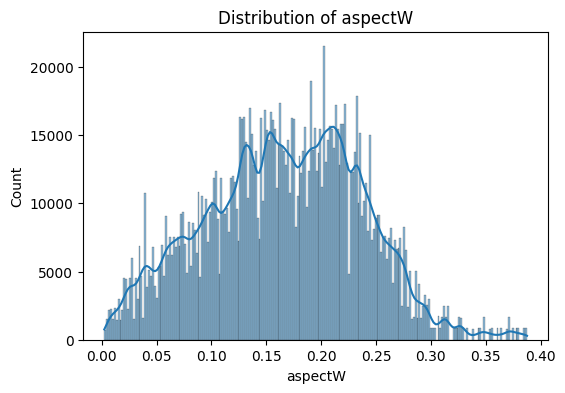

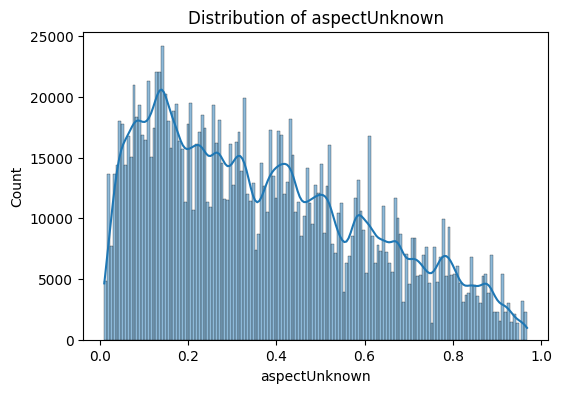

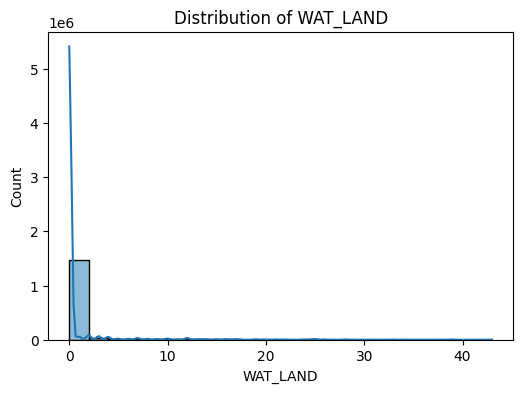

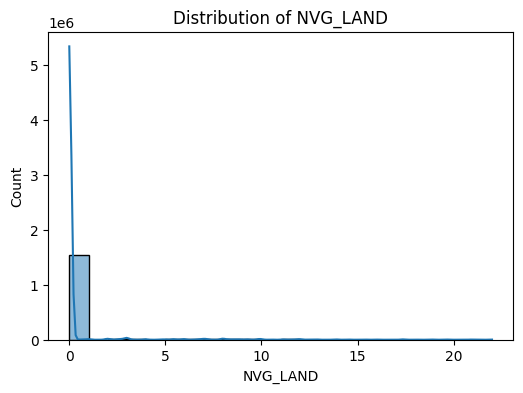

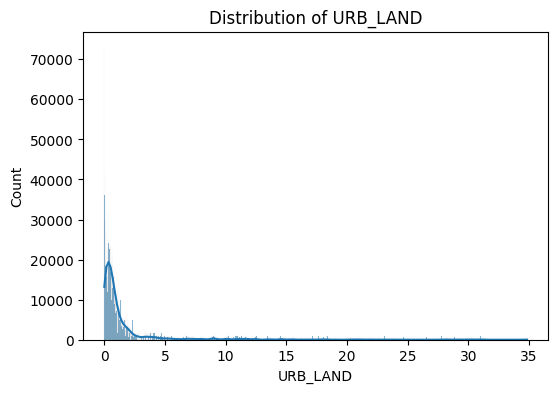

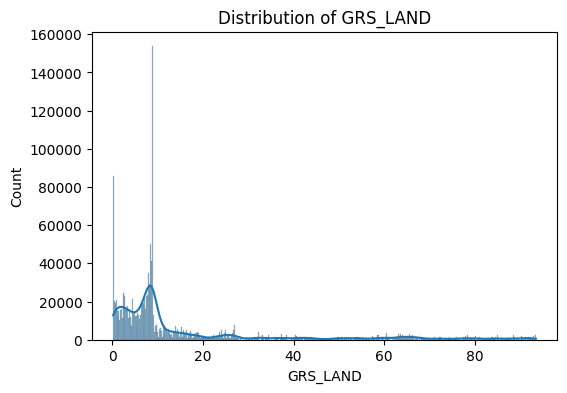

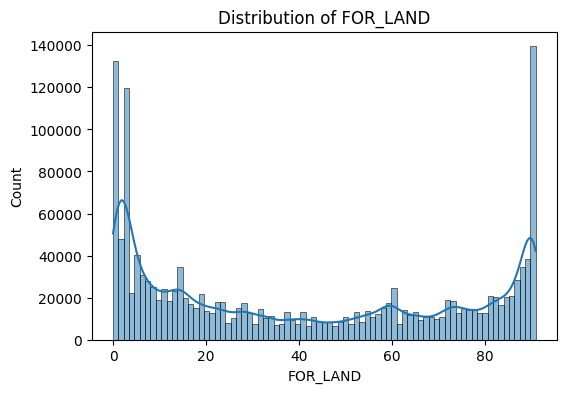

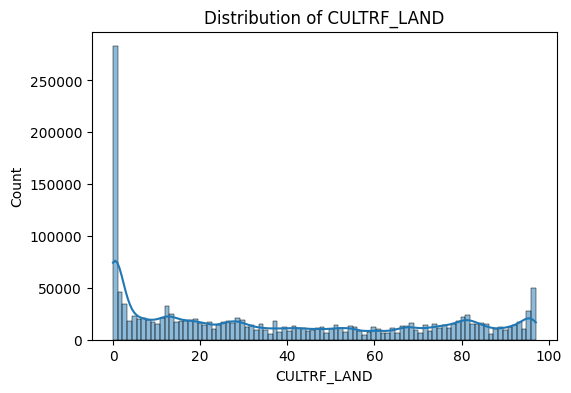

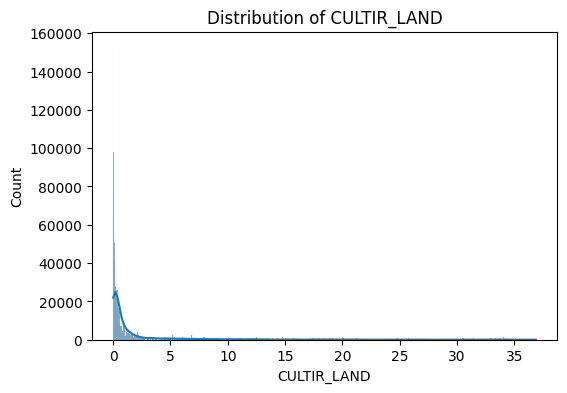

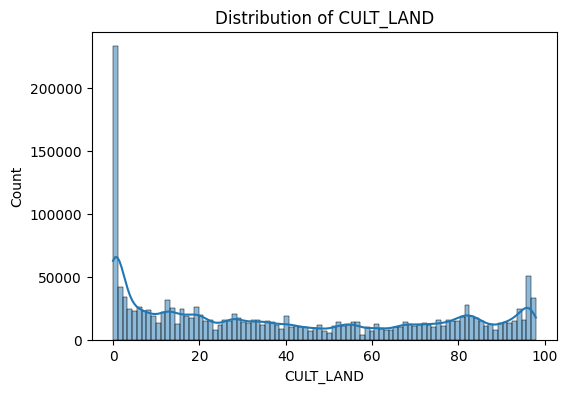

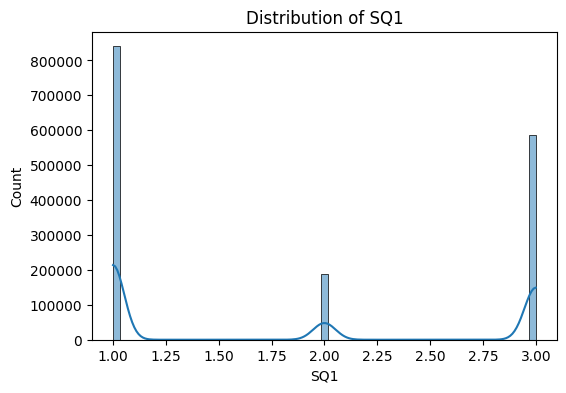

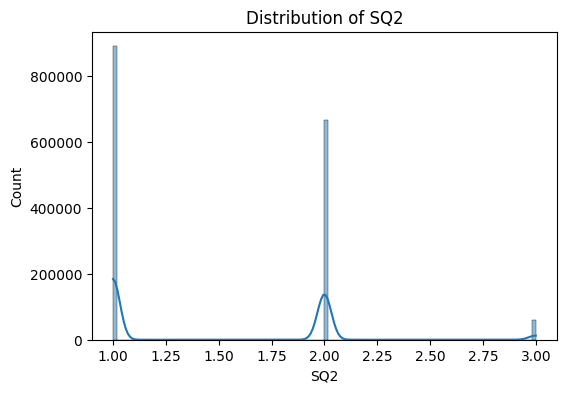

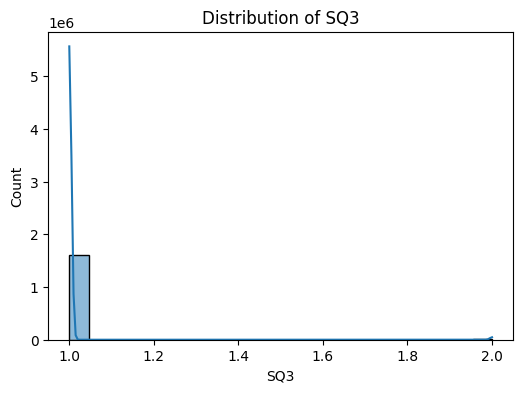

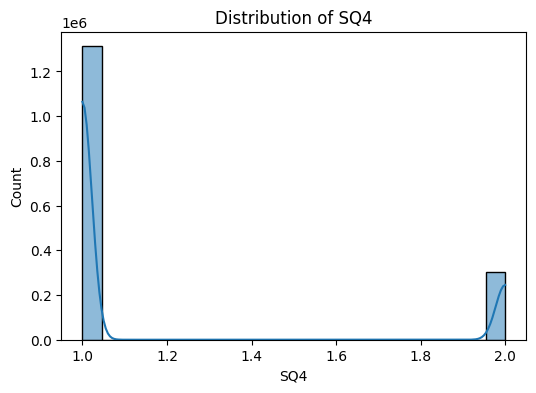

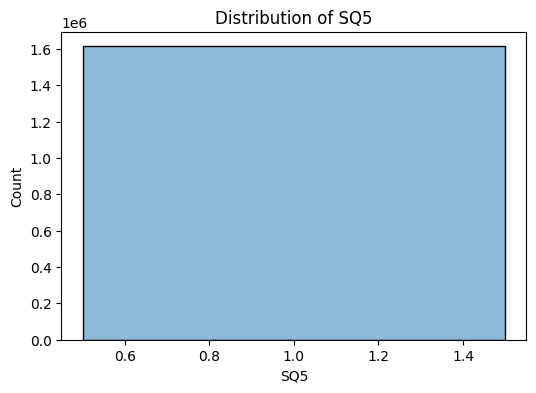

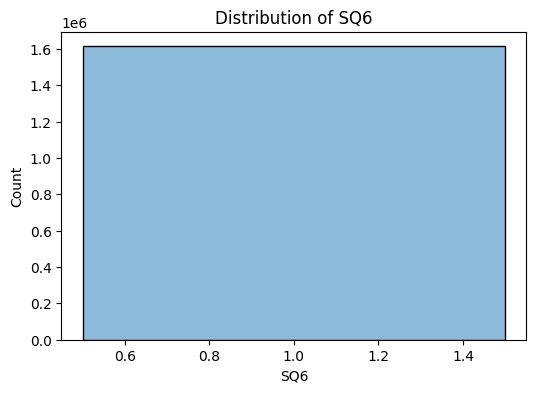

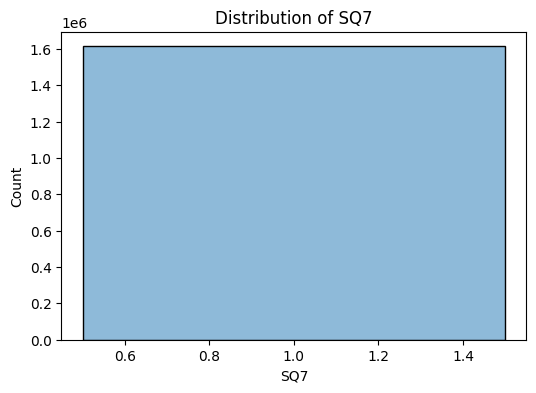

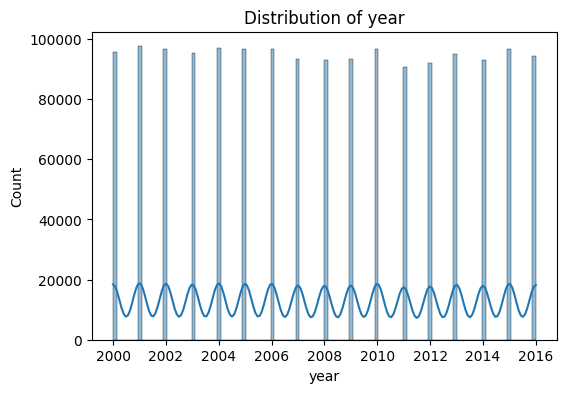

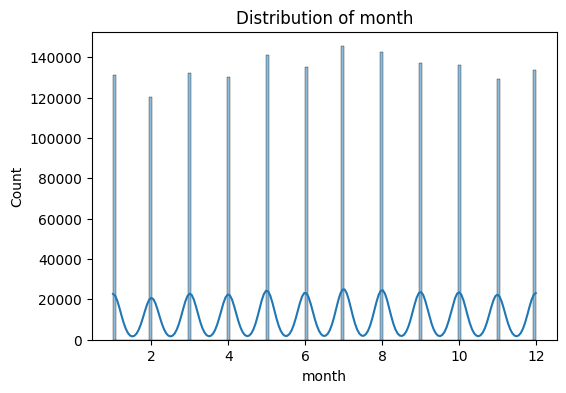

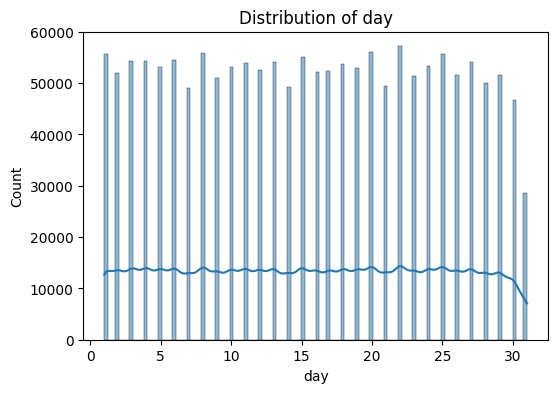

In [16]:
#univariate analysis
for col in data.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()
        